<a href="https://colab.research.google.com/github/mahsaghaderan99/MLP/blob/cross-validation/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Deep* MLP project

In [59]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

#PART4

##Imports

In [60]:
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from os import path,getcwd
import cv2
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from sklearn.model_selection import StratifiedKFold

## load dataset

load mnist dataset 

In [61]:
path = f"{getcwd()}/mnist.npz"

In [62]:
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data(path=path)
training_images = training_images.reshape(60000,28,28)
test_images = test_images.reshape(10000,28,28)

In [63]:
m, n = training_images[0].shape[0], training_images[0].shape[1]
print('The image is ({0}*{1})'.format(m,n))

The image is (28*28)


##Preprocess Data

Normalize images --> map value into (0,1)

In [64]:
training_images = np.array(training_images,np.float64)*(1/255)
test_images = np.array(test_images,np.float64)*(1/255)

Flatten original image --> suitable for output of the network.

In [65]:
x_train = np.reshape(training_images,(training_images.shape[0],m*n))
test_images = np.reshape(test_images,(test_images.shape[0],m*n))
X = np.append(x_train,test_images,0)
Y = np.append(training_labels,test_labels)

##Dataset_overview


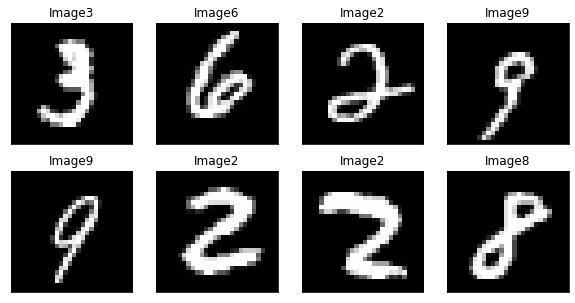

In [84]:
smaple = 11
image_list = []
for i in range(8):
  image_list.append([X[sample+3*i].reshape(m,n), 'Image{0}'.format(Y[sample+3*i]), 'img'])

plotter(image_list,2,4 ,True,10,5)

##Generate Model

In [85]:
def generate_model(layers_number,layers_nodenum,dropout,optimizer,loss,accuracy):
  layers = []
  layers.append(tf.keras.layers.Flatten())
  for i in range(layers_number):
    layers.append(tf.keras.layers.Dense(layers_nodenum[i],activation=tf.nn.relu))
    layers.append(tf.keras.layers.Dropout(dropout[i]))
  layers.append(tf.keras.layers.Dense(10,activation=tf.nn.softmax))
  model = tf.keras.models.Sequential(layers)
  model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy],)
  model.build((None,m*n),)
  model.summary()
  return model


##Run model: train.validation,test

seperate train, validation and test data

In [86]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [102]:
model = generate_model(layers_number=2,
                       layers_nodenum=[20,30],
                       dropout=[0.2,0],
                       optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       accuracy='accuracy')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 20)                15700     
_________________________________________________________________
dropout_18 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 30)                630       
_________________________________________________________________
dropout_19 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                310       
Total params: 16,640
Trainable params: 16,640
Non-trainable params: 0
__________________________________________________

In [106]:
epochs  =30
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='accuracy', mode='max')
history = model.fit(x_train,y_train,validation_data=(x_val,y_val), epochs=epochs,callbacks=[mcp_save],batch_size=10)
model.load_weights('.mdl_wts.hdf5')
accuracy = model.evaluate(x_test,y_test)

Epoch 1/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.2259 - accuracy: 0.9211 - val_loss: 0.2558 - val_accuracy: 0.9286
Epoch 2/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.2026 - accuracy: 0.9304 - val_loss: 0.2625 - val_accuracy: 0.9311
Epoch 3/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.2070 - accuracy: 0.9285 - val_loss: 0.2461 - val_accuracy: 0.9357
Epoch 4/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.1933 - accuracy: 0.9339 - val_loss: 0.2536 - val_accuracy: 0.9321
Epoch 5/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.1906 - accuracy: 0.9354 - val_loss: 0.2432 - val_accuracy: 0.9354
Epoch 6/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.1875 - accuracy: 0.9349 - val_loss: 0.2532 - val_accuracy: 0.9325
Epoch 7/30
1120/1120 [==============================] - 3s 3ms/step - loss: 0.1769 - accuracy: 0.9401 - val_loss: 0.2439 - val_accuracy:

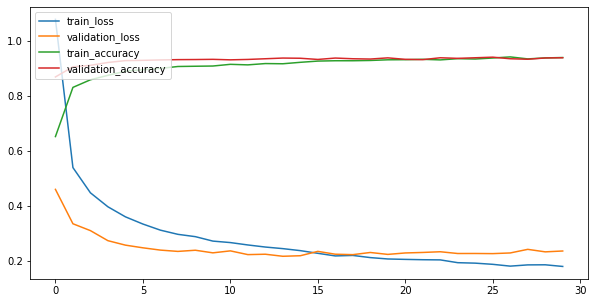

In [105]:
plt.plot(history.history['loss'],)
plt.plot(history.history['val_loss'],)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_loss','validation_loss', 'train_accuracy','validation_accuracy'], loc='upper left')
plt.show()

##Cross validation

In [56]:
seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=11, shuffle=True, random_state=seed)

cvscores = []
step = 0
for train, test in kfold.split(X, Y):	
  model.fit(X[train], Y[train], epochs=25, verbose=0)
  scores = model.evaluate(X[test], Y[test], verbose=0)
  print("step {0} ----- {1} is {2}".format(step,model.metrics_names[1], scores[1]*100))
  step += 1
  cvscores.append(scores[1] * 100)
print("The average of the model accuracy is {0} (+/- {1})".format(np.mean(cvscores), np.std(cvscores)))

step 0 ----- accuracy is 96.1502194404602
step 1 ----- accuracy is 97.29729890823364
step 2 ----- accuracy is 97.65870571136475
step 3 ----- accuracy is 97.54871129989624
step 4 ----- accuracy is 97.54871129989624
step 5 ----- accuracy is 98.05154204368591
step 6 ----- accuracy is 98.14581871032715
step 7 ----- accuracy is 98.4598457813263
step 8 ----- accuracy is 98.01980257034302
step 9 ----- accuracy is 98.06694984436035
step 10 ----- accuracy is 97.97265529632568
The average of the model accuracy is 97.72002371874723 (+/- 0.5891463620185596)


#PART5

##imports

In [ ]:
import tensorflow as tf
from os import path, getcwd, chdir
import cv2
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial


## load dataset

load mnist dataset 

In [ ]:
path = f"{getcwd()}/mnist.npz"

In [ ]:
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data(path=path)
training_images = training_images.reshape(60000,28,28)
test_images = test_images.reshape(10000,28,28)

In [ ]:
m, n = training_images[0].shape[0], training_images[0].shape[1]
print('The image is ({0}*{1})'.format(m,n))

The image is (28*28)


##Preprocess Data and generate train,validation,test

Normalize images --> map value into (0,1)

In [ ]:
training_images = np.array(training_images,np.float64)*(1/255)
test_images = np.array(test_images,np.float64)*(1/255)

Flatten original image --> suitable for output of the network.

In [ ]:
x_train = np.reshape(training_images,(training_images.shape[0],m*n))
test_images = np.reshape(test_images,(test_images.shape[0],m*n))

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(test_images, test_labels, test_size=0.4, random_state=42)

In [ ]:
print('train shape:',x_train.shape[0])
print('train shape:',x_val.shape[0])
print('test shape:',x_test.shape[0])

train shape: 60000
train shape: 4000
test shape: 6000


##Add noise

In [ ]:
def make_noisydata(data,model,var,portion):
  noisy_data = np.empty(data.shape)
  if model == 'gaussian':
    for i in range(data.shape[0]):
      noisy_data[i] = random_noise(data[i],model,var = var)
  elif model == 's&p':
    for i in range(data.shape[0]):
      noisy_data[i] = random_noise(data[i],model,amount=portion)
  return noisy_data

In [ ]:
def add_noise(model,var,portion):
  noisy_train = make_noisydata(x_train,model,var,portion)
  noisy_val = make_noisydata(x_val,model,var,portion)
  noisy_test = make_noisydata(x_test,model,var,portion)
  return noisy_train, noisy_val,noisy_test

##Generate Model


In [ ]:
def generate_model(layers_number,layers_nodenum,dropout,optimizer,loss,accuracy):
  layers = []
  layers.append(tf.keras.layers.Flatten())
  for i in range(layers_number):
    layers.append(tf.keras.layers.Dense(layers_nodenum[i],activation=tf.nn.relu))
    layers.append(tf.keras.layers.Dropout(dropout[i]))
  layers.append(tf.keras.layers.Dense(m*n,activation=tf.nn.softmax))
  model = tf.keras.models.Sequential(layers)
  model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])
  model.build((None,m*n))
  model.summary()
  return model


In [ ]:
def RemoveNoise(model_info,epochs,train=True):
  model = generate_model(model_info['layer_number'],model_info['layer_nodenum'],model_info['dropout_postion'],model_info['optimizer'],model_info['loss'],model_info['accuracy'])
  mcp_save = tf.keras.callbacks.ModelCheckpoint(model_info['best_model_path'], save_best_only=True, monitor='val_cosine_similarity', mode='max')
  if train:
    history = model.fit(n_train,x_train,validation_data= (n_val,x_val), epochs=epochs,callbacks=[mcp_save] )
  model.load_weights(model_info['best_model_path'])
  print('best accurasy on train data is:',model.evaluate(n_train, x_train)[1],)
  print('best accurasy on validation data is:',model.evaluate(n_val, x_val)[1],)
  print('best accurasy on test data is:',model.evaluate(n_test, x_test)[1],)
  return model

In [ ]:
def checktestsample(model,sample):
  y_pred = model.predict(np.array([n_test[sample]]))
  similarity = 1 - spatial.distance.cosine(y_pred[0], x_test[sample])
  y_pred0 = np.reshape(y_pred[0],(m,n))
  image_list = []
  image_list.append([x_test[sample].reshape((m,n)), 'Original Test Image', 'img'])
  image_list.append([n_test[sample].reshape((m,n)), 'Noisy Test Image', 'img'])
  image_list.append([y_pred0, 'Predicted Image', 'img'])
  print("cos similarity between desired and predicted is:%{0}".format(similarity))
  plotter(image_list,1,3 ,True,10,10)

##RUN

In [ ]:
noise_info ={
    'model': 'gaussian',
    'var': 0.5,
    'portion': 0.2
}
model_info={
    'layer_number':3,
    'layer_nodenum' : [254,128,32],
    'dropout_postion': [0,0.1,0],
    'optimizer': tf.keras.optimizers.Adam(),
    'loss': tf.keras.losses.CosineSimilarity(),
    'accuracy':tf.keras.metrics.CosineSimilarity(name='cosine_similarity'),
    'best_model_path':'.mdl_wts.hdf5'
}
n_train, n_val,n_test = add_noise(noise_info['model'],noise_info['var'],noise_info['portion'])
best_model = RemoveNoise(model_info,epochs=35,train=False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 254)               199390    
_________________________________________________________________
dropout_12 (Dropout)         (None, 254)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32640     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)               

cos similarity between desired and predicted is:%0.7658917471877816


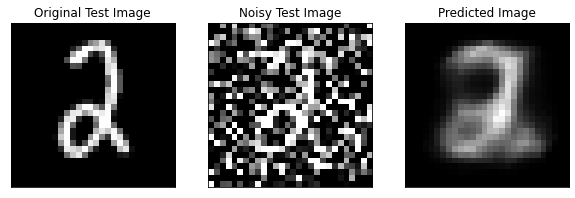

In [ ]:
checktestsample(best_model,26)